<a href="https://colab.research.google.com/github/justinqbui/mini-ViTTransformer/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import math
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

!pip install pytorch_lightning
import pytorch_lightning as pl

In [2]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout = .1):
        """
        A feed forward network after scaled dot product attention
        Params:
        embed_dim = embedding dimension of vector
        hidden_dim = hidden dimension in the FF network, generally 2-4x larger than embed_dim
        dropout = % dropout for training
        """
        super().__init__()
        self.FFN = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x = self.FFN(x)
        return x

In [3]:
class Embedding(nn.Module):
    def __init__(self, img_size =224, patch_size = 14, embed_dim = 768, input_channels = 3):
        """
        A module for implementing Vector embeddings for vision transformers
        Params:
        img_size = integer specifying n x n input image (only works for square images)
            --> defaults to 224 from original ViT paper
        patch_size = integer specifying n x n patch size (only for square images)
            --> defaults to 14, for ormiginal ViT paper, patch_size 14x14 gives us img with 16x16 patches
        embed_ dim = embedding dimension of vector
        input_channels = 3 for color images(R, G, B), 1 for black/white 
        """
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        assert img_size % patch_size == 0
        self.num_patches = (img_size // patch_size) ** 2
        
        # we use convolution to create the projections of input image(3d matrix) to a vector
        # each filter is responsible for creating one patch 
        self.proj = nn.Conv2d(
            in_channels = input_channels,
            out_channels = embed_dim,
            stride = patch_size,
            kernel_size = patch_size
        )

    def forward(self, x):
        """
        converts a tensor of (batch_size x input_channels x height x width)
        to one of tensor of shape (batch_size, num_patches, embed_dim)
        """
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(-2, -1)
        return x
         

In [4]:
def attention(query, key, value):
    """
    calculate scaled dot product attention given a q, k and v
    Params:
    query -> a given query tensor
    key -> a given key tensor
    value -> a given value tensor
    """
    dim = query.shape[-1]
    # (Query * tranpose(key)) / sqrt(dim)
    scores = torch.bmm(query, key.transpose(-2, -1)) / math.sqrt(dim)
    weights = F.softmax(scores, dim = -1)
    return torch.bmm(weights, value)

In [5]:
class AttentionHead(nn.Module):
    """
    Generates the Q, K, V vectors from a given input embedding x 
    and calculates the attention for one head
    Params:
    embed_dim -> embedding dimension of input vector x
    head_dim -> dimension that embed_dim gets transformed into from the qkv transformation
    """
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.to_q = nn.Linear(embed_dim, head_dim)
        self.to_k = nn.Linear(embed_dim, head_dim)
        self.to_v = nn.Linear(embed_dim, head_dim)
    def forward(self, x):
        attn = attention(self.to_q(x), self.to_k(x), self.to_v(x))
        return attn

In [6]:
class MultiHeadAttention(nn.Module):
    """
    Calculates the Multi-Headed attention
    Params:
    num_heads -> number of heads to use, each head_dim is calculated as embed_dim // num_heads 
    embed_dim -> embedding dimension of vector x
    """
    def __init__(self, num_heads, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads 

        self.heads = nn.ModuleList(
            AttentionHead(self.embed_dim, self.head_dim) 
            for _ in range(num_heads)
        )
        self.to_out = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        # calculate attention for each head and concatenate tensor
        x = torch.cat([head(x) for head in self.heads], dim = -1)
        x = self.to_out(x)
        return x

In [7]:
class ViTBlock(nn.Module):
    """
    A full ViT encoder block, with a pre-layer normalization -> MHA -> layernorm ->FF
    Params:
    num_heads -> number of heads to use, each head_dim is calculated as embed_dim // num_heads
    embed_dim -> embedding dimension of vector x
    hidden_dim -> hidden dimension of the Feed Forward network, generally 2-4x larger than embed_dim
    """
    def __init__(self, num_heads, embed_dim, hidden_dim):
        super().__init__()
        #layernorm(prenorm) -> MHA ->layernorm -> FF
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.MHA = MultiHeadAttention(num_heads, embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.FFN = FeedForward(embed_dim, hidden_dim)

    def forward(self, x):

        x = self.layernorm1(x)
        # residual connection
        x = x + self.MHA(x)
        x = self.layernorm2(x)
        #residual connection
        x = x + self.FFN(x)
        return x

In [8]:
class ViTTransformer(pl.LightningModule):
    """
    The Full Vision Transformer comprised of embedding layer -> (num_layers * ViTBlock) ->layernorm -> linear
    Wrapped in a pytorch lightning module for extra functionality 

    Params:
    img_size = integer specifying n x n input image (only works for square images)
    patch_size = integer specifying n x n patch size (only for square images)
    input_channels = 3 for color images(R, G, B), 1 for black/white 
    num_heads -> number of heads to use, each head_dim is calculated as embed_dim // num_heads
    embed_dim = embedding dimension of vector x
    hidden_dim = hidden dimension in the FF network, generally 2-4x larger than embed_dim
    num_layers = number of encoders stacked on top of each, the larger the value the more params and compute required
    num_classes = number of classes in classification task
    dropout = % float for dropout for linear layers

    """
    def __init__(self,img_size, patch_size, input_channels, num_heads, embed_dim, hidden_dim, num_layers, num_classes, dropout = .1):
        super().__init__()
        # embedding -> (num_layers * ViTBlock) -> ->layernorm -> linear-head
        self.embedding = Embedding(
            img_size= img_size,
            patch_size = patch_size, 
            embed_dim = embed_dim, 
            input_channels = input_channels
        )
        
        # we create classification token and append it to the beginning of each sequence
        self.cls_token = nn.Parameter(torch.zeros(1,1, embed_dim))
        self.pos_embeddings = nn.Parameter(torch.zeros(1,1 + self.embedding.num_patches, embed_dim))
        self.layers = nn.ModuleList(
            [ViTBlock(
                num_heads = num_heads,
                embed_dim = embed_dim,
                hidden_dim = hidden_dim,
            ) for _ in range(num_layers)] 
        )
        
        self.layernorm = nn.LayerNorm(embed_dim)
        # linear head for classification
        self.to_out = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):

        batch_size = x.shape[0]
        x = self.embedding(x)

        # add cls token and positional embeddings
        cls_token = self.cls_token.expand(batch_size, -1, -1) # (bs, 1, embed_dim)
        x = torch.cat((cls_token, x), dim = 1) #(bs, 1 + num_patches, embed_dim)
        x = x + self.pos_embeddings

        # go through model
        for layer in self.layers: 
            x = layer(x)

        x = self.layernorm(x)
        cls_token_only = x[:, 0]  # we want only the cls token
        x = self.to_out(cls_token_only)   # linear head for classification
        return x
    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(),lr = 3e-4)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[100, 150])
        return [optim], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.forward(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")


In [9]:
! pip install --quiet "torch>=1.6" "torchmetrics>=0.3" "lightning-bolts" "pytorch-lightning>=1.3" "torchvision"

     |████████████████████████████████| 316 kB 4.0 MB/s 


In [10]:
import os
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
#from torchvision.datasets import CIFAR10
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved

# Some image augmentation for training
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

# we normalize validation set but don't augment data
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

# Loading the datasets
train_ds = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_ds = CIFAR10(root=DATASET_PATH, train=True, transform=val_transform, download=True)
pl.seed_everything(42)
train_set, _ = random_split(train_ds, [45000, 5000])
pl.seed_everything(42)
_, val_set = random_split(val_ds, [45000, 5000])

train_dl = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


Global seed set to 42
Global seed set to 42


In [11]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [12]:
model = ViTTransformer(img_size = 32, patch_size = 4, input_channels= 3, 
                       num_heads = 8, embed_dim = 256, hidden_dim = 512, 
                       num_layers = 2, num_classes = 10, dropout = .1)

trainer = pl.Trainer(enable_progress_bar=True, max_epochs=5, gpus = 1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [13]:
trainer.validate(model,dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.07959999889135361, 'val_loss': 2.443877696990967}
--------------------------------------------------------------------------------


[{'val_acc': 0.07959999889135361, 'val_loss': 2.443877696990967}]

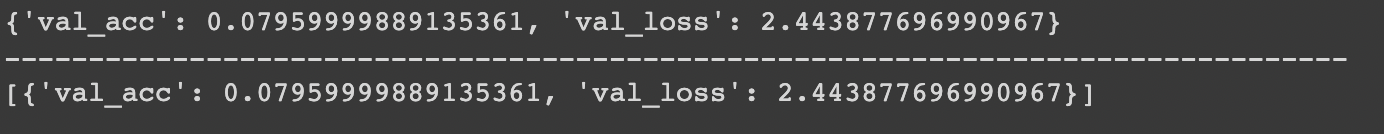

We first evaluate the model with the weights randomly initialized. We should expect about 10% accuracy give or take given that our model is making random guesses since no weight adjustments are being made. (CIFAR10 has 10 classes with 6k images each, meaning random should result in ~10% accuracy)

In [14]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:736: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  "`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 12.5 K
1 | layers    | ModuleList | 1.1 M 
2 | layernorm | LayerNorm  | 512   
3 | to_out    | Linear     | 2.6 K 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.347     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
trainer.validate(model,dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.631600022315979, 'val_loss': 1.0349743366241455}
--------------------------------------------------------------------------------


[{'val_acc': 0.631600022315979, 'val_loss': 1.0349743366241455}]

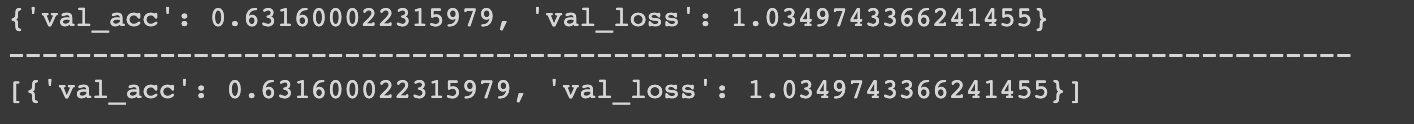

Great, we can see that our model actually is actually learning. Since our model is small (only 2 encoders stacked and ~1M parameters) and only trained for 5 epochs, we shouldn't expect SOTA results. Furthermore, transformer based vision architectures generally scale much better in performance with significantly more data, more so than it's CNN counterparts. 